In [79]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# Function to load preprocessed CIFAR-10 data
def load_preprocessed_cifar10_data():
    train_data_path = 'D:\\ASU\\Fall 2024\\EEE549\\Final term project\\sml-final\\data\\preprocessed\\cifar10\\preprocessed_train_cifar.pt'
    test_data_path = 'D:\\ASU\\Fall 2024\\EEE549\\Final term project\\sml-final\\data\\preprocessed\\cifar10\\preprocessed_test_cifar.pt'

    # Load and unpack the train and test data and labels
    train_data, train_targets = torch.load(train_data_path, weights_only=False)
    test_data, test_targets = torch.load(test_data_path, weights_only=False)

    # Reshape data for usage in non-CNN models (flattening the images)
    X_train = train_data.reshape(train_data.shape[0], -1)
    X_test = test_data.reshape(test_data.shape[0], -1)
    y_train = train_targets.numpy()
    y_test = test_targets.numpy()

    return X_train, X_test, y_train, y_test

# Load and preprocess data
X_train, X_test, y_train, y_test = load_preprocessed_cifar10_data()

In [80]:
# Splitting data for validation (optional)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 3072)
(2000, 3072)
(8000,)
(2000,)


In [81]:
X_train = X_train.reshape(-1, 3, 32, 32)
X_val = X_val.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)

In [82]:
print(X_train.shape)
print(X_test.shape)

(8000, 3, 32, 32)
(2000, 3, 32, 32)


In [83]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long))

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [84]:
print("Train dataset length:", len(train_dataset))
print("First item in train dataset:", train_dataset[0])

Train dataset length: 8000
First item in train dataset: (tensor([[[125., 191., 153.,  ...,  92.,  87., 133.],
         [114., 118., 181.,  ..., 168., 138., 138.],
         [204., 179., 123.,  ...,  58.,  97.,  85.],
         ...,
         [192., 176., 115.,  ..., 134., 196., 170.],
         [121., 186., 115.,  ..., 131., 120., 189.],
         [157., 122., 193.,  ..., 204., 173., 135.]],

        [[201., 168., 129.,  ..., 131., 198., 167.],
         [122., 187.,  92.,  ..., 122., 126., 191.],
         [178., 123., 191.,  ..., 203., 164., 136.],
         ...,
         [ 89., 101.,  96.,  ...,  86.,  62., 121.],
         [123.,  91., 127.,  ...,  68., 101.,  68.],
         [ 36.,  43.,  27.,  ..., 109.,  84., 122.]],

        [[122.,  82., 115.,  ...,  84.,  62.,  89.],
         [ 92.,  66.,  83.,  ...,  58.,  85.,  60.],
         [ 29.,  34.,  20.,  ...,  86.,  83., 117.],
         ...,
         [ 24.,  24.,  13.,  ...,  57., 109.,  91.],
         [ 67., 129., 110.,  ..., 174., 135., 209

In [85]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)  # Adjust based on your pooling and convolutional settings
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)  # Flatten the features
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss criterion, and optimizer
cnn = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Assuming trainloader and testloader are set up properly
num_epochs = 100
learning_rates = [0.001, 0.01, 0.05, 0.1]
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    cnn.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for data, target in trainloader:
        optimizer.zero_grad()
        output = cnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct_train += (predicted == target).sum().item()
        total_train += target.size(0)

    train_loss = total_train_loss / total_train
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Test phase
    cnn.eval()
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, target in testloader:
            output = cnn(data)
            loss = criterion(output, target)
            total_test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            correct_test += (predicted == target).sum().item()
            total_test += target.size(0)

    test_loss = total_test_loss / total_test
    test_acc = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

Epoch 1/100, Train Loss: 0.0112, Test Loss: 0.0086, Train Acc: 64.38%, Test Acc: 73.95%
Epoch 2/100, Train Loss: 0.0081, Test Loss: 0.0084, Train Acc: 74.95%, Test Acc: 75.35%
Epoch 3/100, Train Loss: 0.0074, Test Loss: 0.0077, Train Acc: 77.92%, Test Acc: 76.25%
Epoch 4/100, Train Loss: 0.0069, Test Loss: 0.0078, Train Acc: 79.46%, Test Acc: 76.70%
Epoch 5/100, Train Loss: 0.0064, Test Loss: 0.0079, Train Acc: 81.38%, Test Acc: 76.80%
Epoch 6/100, Train Loss: 0.0059, Test Loss: 0.0081, Train Acc: 83.03%, Test Acc: 77.10%
Epoch 7/100, Train Loss: 0.0056, Test Loss: 0.0082, Train Acc: 83.99%, Test Acc: 76.85%
Epoch 8/100, Train Loss: 0.0049, Test Loss: 0.0084, Train Acc: 86.70%, Test Acc: 77.00%
Epoch 9/100, Train Loss: 0.0046, Test Loss: 0.0092, Train Acc: 87.33%, Test Acc: 76.10%
Epoch 10/100, Train Loss: 0.0042, Test Loss: 0.0092, Train Acc: 88.61%, Test Acc: 75.50%
Epoch 11/100, Train Loss: 0.0036, Test Loss: 0.0109, Train Acc: 90.69%, Test Acc: 75.70%
Epoch 12/100, Train Loss: 0.00

In [ ]:
# # Empty lists to collect data
# all_outputs = []
# all_labels = []
# all_preds = []

# # Assuming testloader is set up correctly
# cnn.eval()
# with torch.no_grad():
#     for data, target in testloader:
#         # output = cnn(data)
#         images, labels = data
#         outputs = cnn(images)
#         _, predicted = torch.max(outputs.data, 1)
#         # Check output size and ensure correct probability extraction
#         # print(output.shape)  # Debug: Check the shape of the output tensor
#         all_preds.extend(predicted.numpy())
#         probabilities = torch.softmax(output, dim=1)[:, 1]  # Assuming class '1' is the positive class
#         all_outputs.extend(probabilities.numpy())
#         all_labels.extend(target.numpy())

#         # Debug: Check if data is being collected
#         # print(f'Collected {len(probabilities)} outputs and {len(target)} labels this batch')

# # Convert lists to numpy arrays for further processing with ROC
# all_outputs = np.array(all_outputs)
# all_labels = np.array(all_labels)
# all_preds = np.array(all_preds)

# # print(f'Total collected labels: {len(all_labels)}')  # Should be greater than zero
# # print(f'Total collected outputs: {len(all_outputs)}')  # Should be equal to number of labels

In [86]:
# Empty lists to collect data
all_outputs = []
all_labels = []
all_preds = []

# Assuming testloader is set up correctly
cnn.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)

        # Append predictions
        all_preds.extend(predicted.cpu().numpy())

        # Assuming you're interested in probabilities of the positive class (class index 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        all_outputs.extend(probabilities.cpu().numpy())

        # Append actual labels
        all_labels.extend(labels.cpu().numpy())

        # Debug: Check if data is being collected
        print(f'Collected {len(probabilities)} outputs and {len(labels)} labels this batch')

# Convert lists to numpy arrays for further processing with ROC
all_outputs = np.array(all_outputs)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

print(f'Total collected labels: {len(all_labels)}')  # Should be greater than zero
print(f'Total collected outputs: {len(all_outputs)}')  # Should be equal to number of labels

Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels this batch
Collected 64 outputs and 64 labels

              precision    recall  f1-score   support

        Deer       0.74      0.83      0.78      1000
       Horse       0.81      0.70      0.75      1000

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



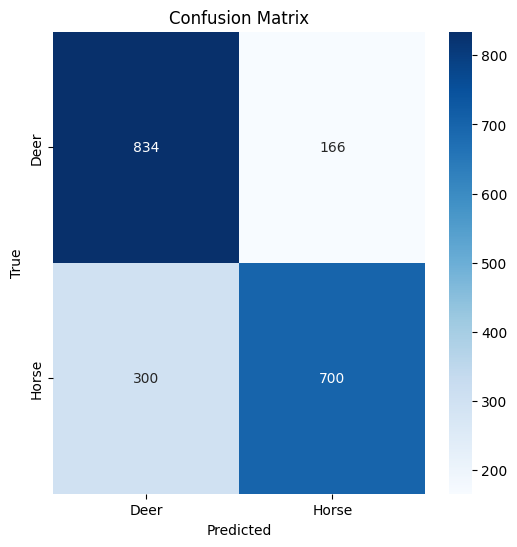

In [87]:
# Print classification report
print(classification_report(all_labels, all_preds, target_names=['Deer', 'Horse']))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Deer', 'Horse'], yticklabels=['Deer', 'Horse'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [88]:
# with torch.no_grad():
#     for data, targets in testloader:
#         outputs = cnn(data)
#         _, predicted = torch.max(outputs, 1)
#         all_preds.extend(predicted.cpu().numpy())  # Collect predictions
#         all_labels.extend(targets.cpu().numpy())  # Collect actual labels


# # Print classification report
# print(classification_report(all_labels, all_preds, target_names=['Deer', 'Horse']))

# # Plot confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Deer', 'Horse'], yticklabels=['Deer', 'Horse'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

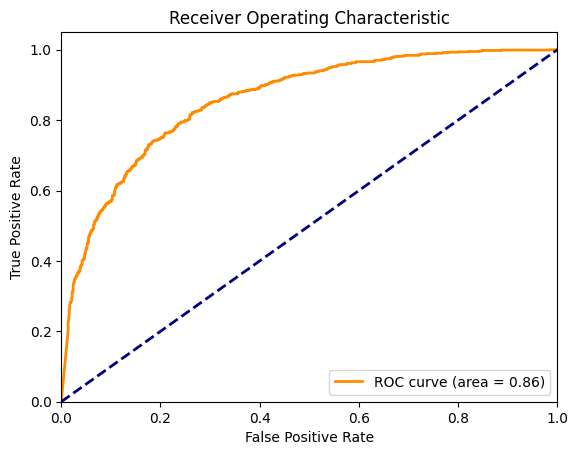

In [89]:
if len(all_labels) > 0 and len(all_outputs) > 0:
    fpr, tpr, _ = roc_curve(all_labels, all_outputs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("No data collected. Check data loading and model output steps.")

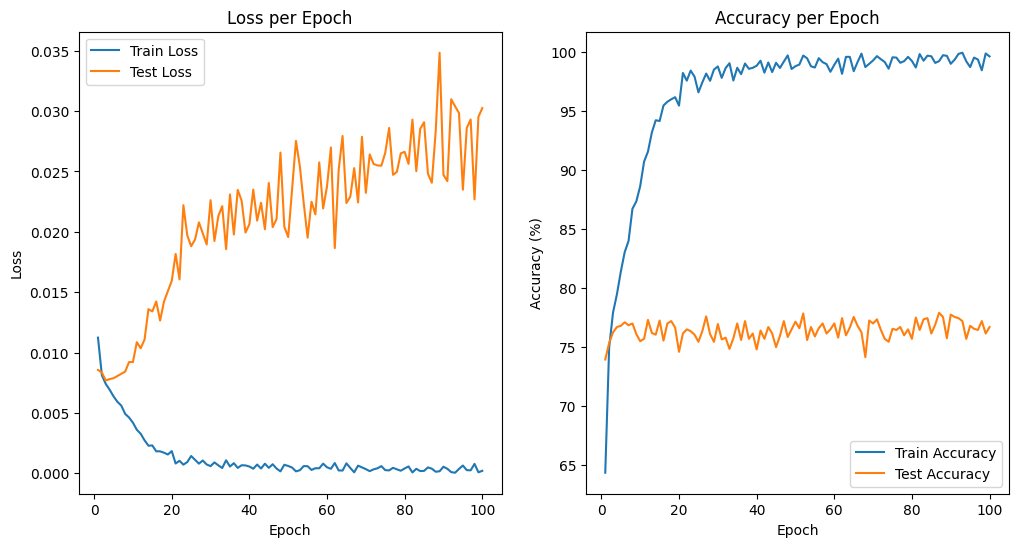

In [90]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Learning Rate: 0.001, Train Accuracy: 42.474998474121094, Test Accuracy: 40.849998474121094
Learning Rate: 0.01, Train Accuracy: 99.5250015258789, Test Accuracy: 99.55000305175781
Learning Rate: 0.05, Train Accuracy: 0.0, Test Accuracy: 0.0
Learning Rate: 0.1, Train Accuracy: 100.0, Test Accuracy: 100.0
Train Accuracies: [42.474998474121094, 99.5250015258789, 0.0, 100.0]
Test Accuracies: [40.849998474121094, 99.55000305175781, 0.0, 100.0]


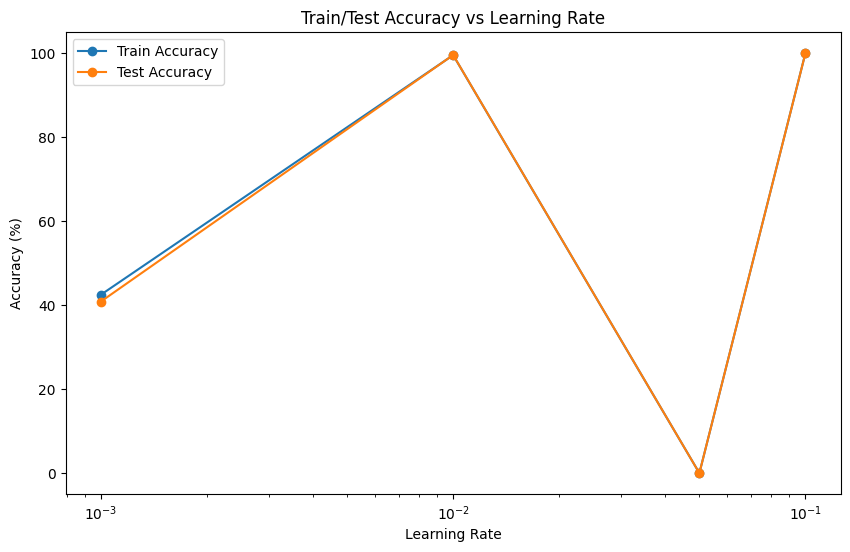

In [91]:
learning_rates = [0.001, 0.01, 0.05, 0.1]
train_accuracies = []
test_accuracies = []

# Clear lists at the start
train_accuracies.clear()
test_accuracies.clear()

for lr in learning_rates:
    cnn = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)

    # Assuming trainloader and testloader are set up properly
    # Train model
    cnn.train()
    for epoch in range(10):  # Use more epochs in practice
        for data, target in trainloader:
            optimizer.zero_grad()
            output = cnn(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluate model on training data
    cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in trainloader:
            outputs = cnn(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).eq(target.data).sum()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy.item())

    # Evaluate model on testing data
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in testloader:
            outputs = cnn(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).eq(target.data).sum()
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy.item())

    print(f'Learning Rate: {lr}, Train Accuracy: {train_accuracy.item()}, Test Accuracy: {test_accuracy.item()}')

print(f'Train Accuracies: {train_accuracies}')
print(f'Test Accuracies: {test_accuracies}')

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(learning_rates, test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy vs Learning Rate')
plt.xscale('log')  # Since learning rates can vary by orders of magnitude
plt.legend()
plt.show()